# Tabular data linearization

This example shows how to table-aware linearization in Textractor can preserve cell text integrity and improve retrieval in a question answering task.

## Installation

To begin, install the `amazon-textract-textractor` package using pip.

`pip install amazon-textract-textractor`

There are various sets of dependencies available to tailor your installation to your use case. The base package will have sensible default, but you may want to install the PDF extra dependencies if your workflow uses PDFs with `pip install amazon-textract-textractor[pdf]`. You can read more on extra dependencies [in the documentation](https://aws-samples.github.io/amazon-textract-textractor/installation.html)

## Calling Textract

In [1]:
import os
from PIL import Image
from textractor import Textractor
from textractor.visualizers.entitylist import EntityList
from textractor.data.constants import TextractFeatures
from textractor.data.text_linearization_config import TextLinearizationConfig

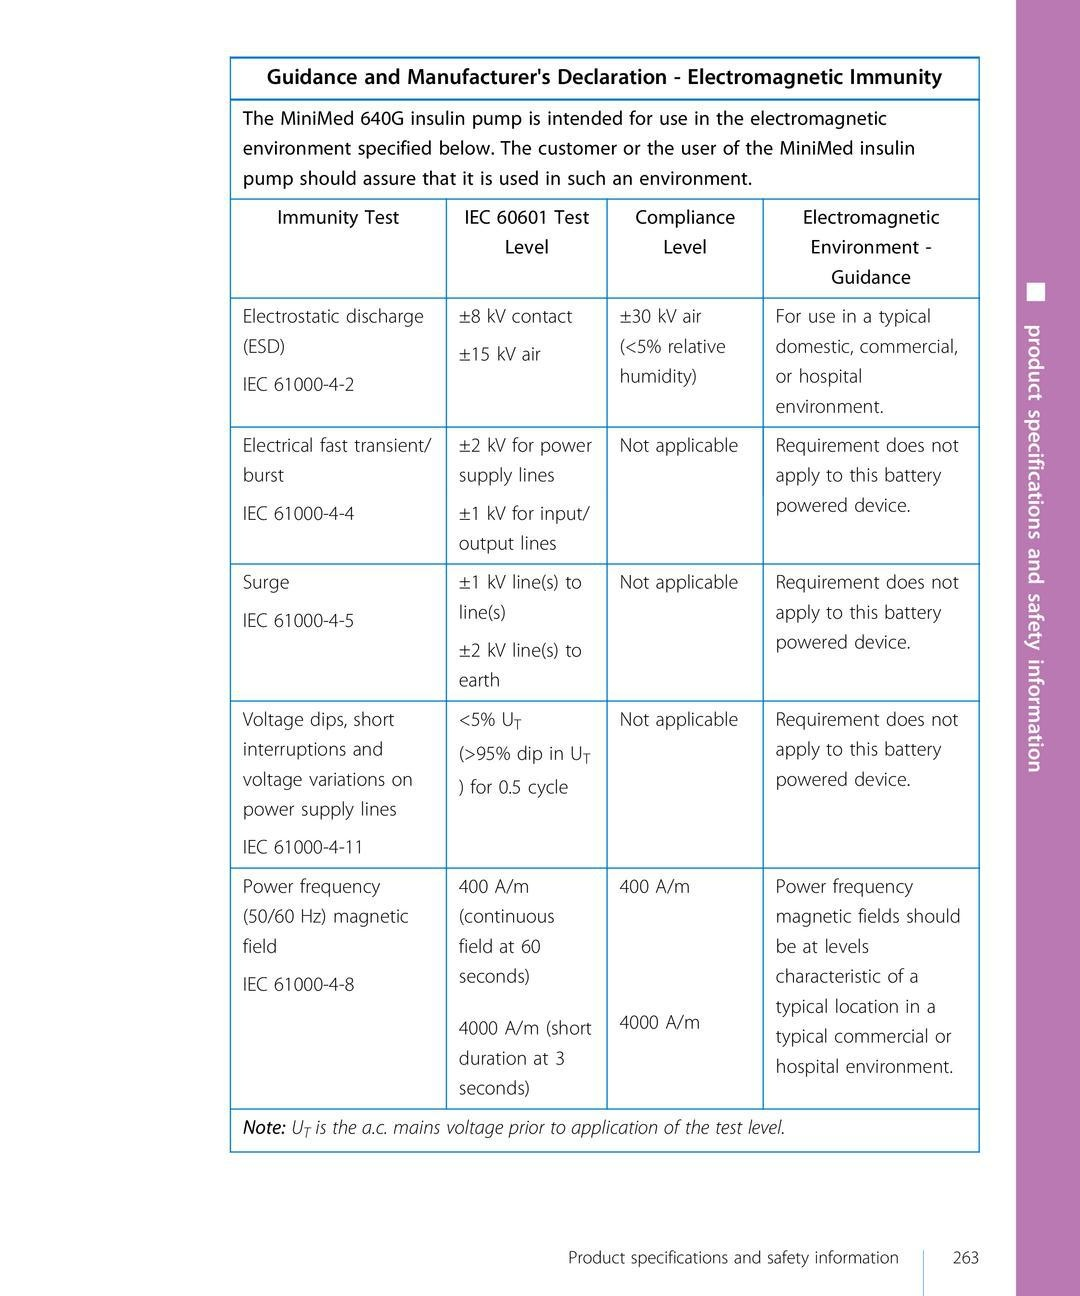

In [2]:
image = Image.open("../../../tests/fixtures/multiline_cells.jpeg")
image

In [3]:
extractor = Textractor(region_name="us-west-2")

document = extractor.detect_document_text(
    file_source=image,
    save_image=True
)

In [4]:
raw_text = document.get_text(TextLinearizationConfig(max_number_of_consecutive_new_lines=1))
print(raw_text.replace("\n", " "))

Guidance and Manufacturer's Declaration - Electromagnetic Immunity   The MiniMed 640G insulin pump is intended for use in the electromagnetic   environment specified below. The customer or the user of the MiniMed insulin   pump should assure that it is used in such an environment.   Immunity Test   IEC 60601 Test   Compliance   Electromagnetic   Level   Level   Environment -   Guidance   Electrostatic discharge   +8 kV contact   +30 kV air   For use in a typical   (ESD)   15 kV air   (<5% relative   domestic, commercial,   IEC 61000-4-2   humidity)   or hospital   environment.   Electrical fast transient/   +2 kV for power   Not applicable   Requirement does not   burst   supply lines   apply to this battery   IEC 61000-4-4   +1 kV for input/   powered device.   output lines   Surge   +1 kV line(s) to   Not applicable   Requirement does not   IEC 61000-4-5   line(s)   apply to this battery   2 kV line(s) to   powered device.   earth   Voltage dips, short   <5% UT   Not applicable   Req

In [5]:
extractor = Textractor(region_name="us-west-2")

document = extractor.analyze_document(
    file_source=image,
    features=[TextractFeatures.TABLES], 
    save_image=True
)

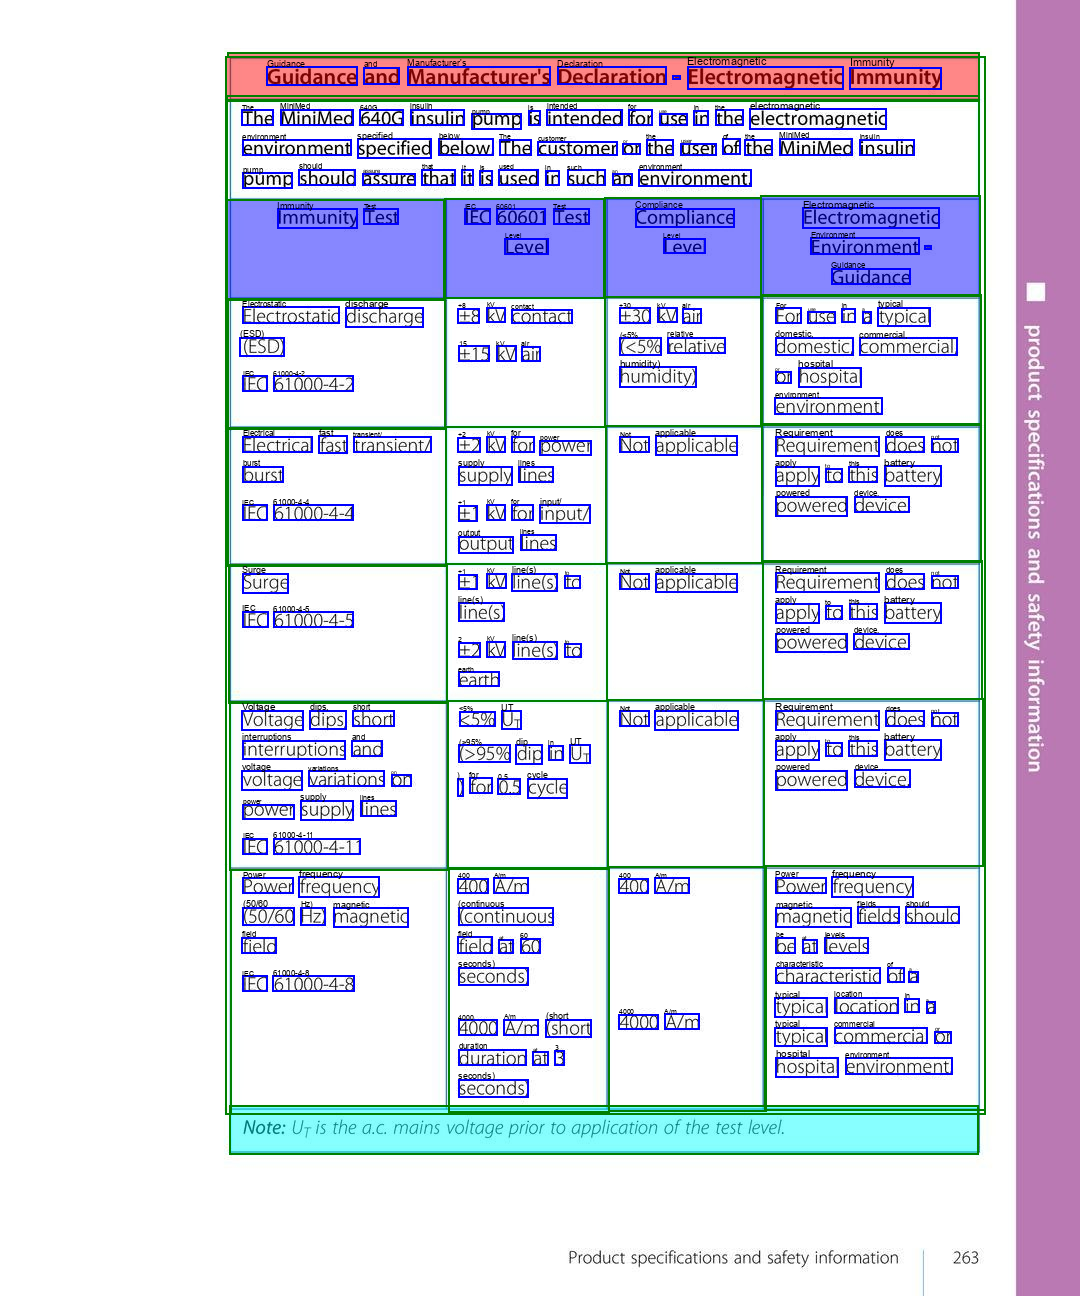

In [6]:
document.tables[0].visualize()

In [7]:
table_aware_text = document.tables[0].get_text(TextLinearizationConfig(table_linearization_format='markdown'))
print(table_aware_text)

| 0                                                                                                                                                                                                                | 1                                                                               | 2                                  | 3                                                                                                                                         |
|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------|
| Guidance and Manufacturer's Declaration - Electromagne

The above is a table in the markdown format, we can paste in in a new cell to see it rendered properly. Note that we set `table_column_header_threshold=0.5` otherwise the  top row would not be identified as a header due to the first cell not being a header itself (see in blue above).

| 0                                                                                                                                                                                                                | 1                                                                               | 2                                  | 3                                                                                                                                         |
|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------|------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------|
| Guidance and Manufacturer's Declaration - Electromagnetic Immunity                                                                                                                                               |                                                                                 |                                    |                                                                                                                                           |
| The MiniMed 640G insulin pump is intended for use in the electromagnetic environment specified below. The customer or the user of the MiniMed insulin pump should assure that it is used in such an environment. |                                                                                 |                                    |                                                                                                                                           |
| Immunity Test                                                                                                                                                                                                    | IEC 60601 Test Level                                                            | Compliance Level                   | Electromagnetic Environment - Guidance                                                                                                    |
| Electrostatic discharge (ESD) IEC 61000-4-2                                                                                                                                                                      | +8 kV contact 15 kV air                                                         | +30 kV air (<5% relative humidity) | For use in a typical domestic, commercial, or hospital environment.                                                                       |
| Electrical fast transient/ burst IEC 61000-4-4                                                                                                                                                                   | +2 kV for power supply lines +1 kV for input/ output lines                      | Not applicable                     | Requirement does not apply to this battery powered device.                                                                                |
| Surge IEC 61000-4-5                                                                                                                                                                                              | +1 kV line(s) to line(s) 2 kV line(s) to earth                                  | Not applicable                     | Requirement does not apply to this battery powered device.                                                                                |
| Voltage dips, short interruptions and voltage variations on power supply lines IEC 61000-4-11                                                                                                                    | <5% UT (>95% dip in UT ) for 0.5 cycle                                          | Not applicable                     | Requirement does not apply to this battery powered device.                                                                                |
| Power frequency (50/60 Hz) magnetic field IEC 61000-4-8                                                                                                                                                          | 400 A/m (continuous field at 60 seconds) 4000 A/m (short duration at 3 seconds) | 400 A/m 4000 A/m                   | Power frequency magnetic fields should be at levels characteristic of a typical location in a typical commercial or hospital environment. |

With the two versions of this tables, we then ask Claude questions pertaining to the document

In [8]:
import json 
import boto3

def get_response_from_claude(context, prompt_data):
    body = json.dumps({
        "prompt": f"""Human: Given the following document:
        {context}
        Answer the following:\n {prompt_data}
        Assistant:""",
        "max_tokens_to_sample": 2000,
        "top_k": 1,
    })
    modelId = f'anthropic.claude-instant-v1' # change this to use a different version from the model provider
    accept = '*/*'
    contentType = 'application/json'

    response = bedrock.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
    response_body = json.loads(response.get('body').read())
    answer = response_body.get('completion')

    return answer

os.environ["AWS_DEFAULT_REGION"] = "us-west-2"
os.environ["BEDROCK_ENDPOINT_URL"] = "https://bedrock-runtime.us-west-2.amazonaws.com"

bedrock = boto3.client(service_name='bedrock-runtime',region_name='us-west-2',endpoint_url='https://bedrock-runtime.us-west-2.amazonaws.com')

In [9]:
question = "What is the compliance level for IEC 61000-4-2?"

IEC 61000-4-2 is the electrostatic discharge test, the correct answer is +30 kV air (<5% relative humidity).

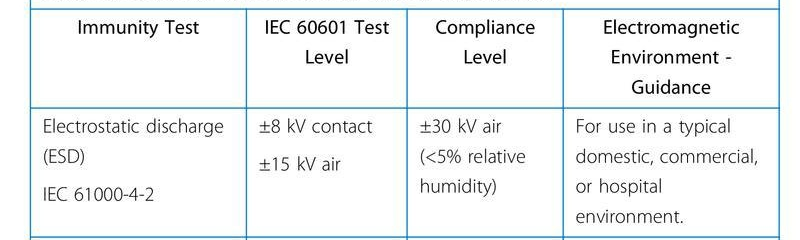

In [10]:
document.pages[0].image.crop((200, 190, 1000, 430))

In [11]:
print(get_response_from_claude(raw_text, question))

 Based on the document, the compliance level for IEC 61000-4-2 (Electrostatic discharge) is:

+8 kV contact 
+30 kV air
15 kV air (<5% relative humidity)


We see that Claude using the raw text is unable to extract the correct answer as the `IEC 60601 Test Level` and `Compliance Level are interlaced`, with the resulting text being: 

```
Electrostatic discharge   +8 kV contact   +30 kV air   For use in a typical   (ESD)   15 kV air   (<5% relative   domestic, commercial,   IEC 61000-4-2   humidity)   or hospital   environment.
```

If instead we use the table-aware linearization, the answer is available and properly aligned in the text, leading to a proper extraction:

In [12]:
print(get_response_from_claude(table_aware_text, question))

 Based on the document, the compliance level for IEC 61000-4-2 (Electrostatic discharge (ESD)) is:
+30 kV air (<5% relative humidity)


## Conclusion

By leveraging Textract Tables, we can build a better text representation of the tabular data, leading to a better performance in question answering tasks.